# Practical Application III: Comparing Classifiers

**Overview**: In this practical application, your goal is to compare the performance of the classifiers we encountered in this section, namely K Nearest Neighbor, Logistic Regression, Decision Trees, and Support Vector Machines.  We will utilize a dataset related to marketing bank products over the telephone.  



### Getting Started

Our dataset comes from the UCI Machine Learning repository [link](https://archive.ics.uci.edu/ml/datasets/bank+marketing).  The data is from a Portugese banking institution and is a collection of the results of multiple marketing campaigns.  We will make use of the article accompanying the dataset [here](CRISP-DM-BANK.pdf) for more information on the data and features.



### Problem 1: Understanding the Data

To gain a better understanding of the data, please read the information provided in the UCI link above, and examine the **Materials and Methods** section of the paper.  How many marketing campaigns does this data represent?

#### The dataset collected is related to 17 campaigns that occurred between May 2008 and November 2010, corresponding to a total of 79354 contacts.

### Problem 2: Read in the Data

Use pandas to read in the dataset `bank-additional-full.csv` and assign to a meaningful variable name.

In [344]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyClassifier
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
import time
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

In [345]:
df = pd.read_csv('data/bank-additional-full.csv', sep = ';')

In [346]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


### Problem 3: Understanding the Features


Examine the data description below, and determine if any of the features are missing values or need to be coerced to a different data type.


```
Input variables:
# bank client data:
1 - age (numeric)
2 - job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
3 - marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
4 - education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
5 - default: has credit in default? (categorical: 'no','yes','unknown')
6 - housing: has housing loan? (categorical: 'no','yes','unknown')
7 - loan: has personal loan? (categorical: 'no','yes','unknown')
# related with the last contact of the current campaign:
8 - contact: contact communication type (categorical: 'cellular','telephone')
9 - month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
10 - day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
11 - duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.
# other attributes:
12 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
13 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
14 - previous: number of contacts performed before this campaign and for this client (numeric)
15 - poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')
# social and economic context attributes
16 - emp.var.rate: employment variation rate - quarterly indicator (numeric)
17 - cons.price.idx: consumer price index - monthly indicator (numeric)
18 - cons.conf.idx: consumer confidence index - monthly indicator (numeric)
19 - euribor3m: euribor 3 month rate - daily indicator (numeric)
20 - nr.employed: number of employees - quarterly indicator (numeric)

Output variable (desired target):
21 - y - has the client subscribed a term deposit? (binary: 'yes','no')
```



### Problem 4: Understanding the Task

After examining the description and data, your goal now is to clearly state the *Business Objective* of the task.  State the objective below.

In [347]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

### Business objective

#### Predict if customer will accept the long term deposit scheme

### Problem 5: Engineering Features

Now that you understand your business objective, we will build a basic model to get started.  Before we can do this, we must work to encode the data.  Using just the bank information features, prepare the features and target column for modeling with appropriate encoding and transformations.

In [348]:
# create input data and label

X = df.drop(columns=['y'])
y = df['y'].apply(lambda x: 1 if x == 'yes' else 0)

In [349]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 20 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

In [350]:
y.info()

<class 'pandas.core.series.Series'>
RangeIndex: 41188 entries, 0 to 41187
Series name: y
Non-Null Count  Dtype
--------------  -----
41188 non-null  int64
dtypes: int64(1)
memory usage: 321.9 KB


In [351]:
# Define which numeric and categorical features to be used for training the model

numeric_features = ['age', 'duration', 'campaign', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']
categorical_features = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome']

print(f"Number of numeric features = {len(numeric_features)}")
print(f"Number of categorical features = {len(categorical_features)}")

Number of numeric features = 10
Number of categorical features = 10


In [352]:
# Transform columns. Numeric values are scaled and categorical values are one hot encoded.

processor = ColumnTransformer(
    transformers = [
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(), categorical_features)
    ]
)

processor.fit(X)
X_transformed = processor.transform(X)

print(X_transformed)

[[ 1.53303429  0.01047142 -0.56592197 ...  0.          1.
   0.        ]
 [ 1.62899323 -0.42150051 -0.56592197 ...  0.          1.
   0.        ]
 [-0.29018564 -0.12451981 -0.56592197 ...  0.          1.
   0.        ]
 ...
 [ 1.53303429 -0.26722482 -0.20490853 ...  0.          1.
   0.        ]
 [ 0.38152696  0.70856893 -0.56592197 ...  0.          1.
   0.        ]
 [ 3.26029527 -0.07438021  0.15610492 ...  1.          0.
   0.        ]]


### Problem 6: Train/Test Split

With your data prepared, split it into a train and test set.

In [353]:
X_train, X_test, y_train, y_test = train_test_split(X_transformed, y)

### Problem 7: A Baseline Model

Before we build our first model, we want to establish a baseline.  What is the baseline performance that our classifier should aim to beat?

In [354]:
baseline_model = DummyClassifier(strategy='most_frequent', random_state=42)
baseline_model.fit(X_train, y_train)

baseline_acc = baseline_model.score(X_test, y_test)

print(f"Baseline accuracy  = {baseline_score}")

Baseline accuracy  = 0.8862775565698747


### Problem 8: A Simple Model

Use Logistic Regression to build a basic model on your data.  

In [355]:
# Build a pipeline for Logistic Regression classifier
lgr_model = Pipeline(
    steps = [
        ('classifier', LogisticRegression()) 
    ]
)

st = time.time()
lgr_model.fit(X_train, y_train)
et = time.time()

lgr_train_time = et - st
lgr_train_acc = lgr_model.score(X_train, y_train)
lgr_test_acc = lgr_model.score(X_test, y_test)

### Problem 9: Score the Model

What is the accuracy of your model?

In [356]:
print(f"Logistic regression classifier model train time = {lgr_train_time: .4f} sec")
print(f"Logistic regression classifier model train acc = {lgr_train_acc}")
print(f"Logistic regression classifier model test acc = {lgr_test_acc}")

Logistic regression classifier model train time =  0.0916 sec
Logistic regression classifier model train acc = 0.9105241008708038
Logistic regression classifier model test acc = 0.9136641740312712


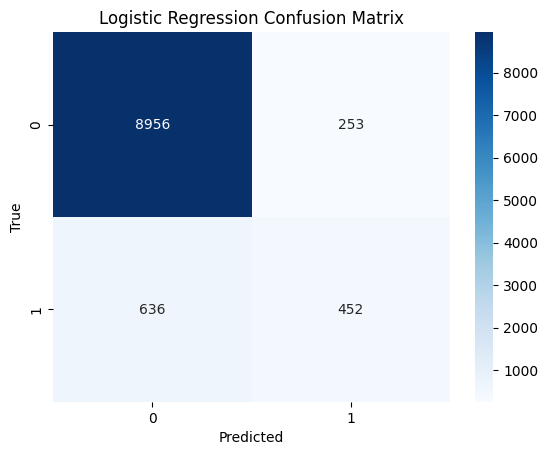

In [357]:
# Plot confusion matrix
y_pred = lgr_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Logistic Regression Confusion Matrix')
plt.show()

### Problem 10: Model Comparisons

Now, we aim to compare the performance of the Logistic Regression model to our KNN algorithm, Decision Tree, and SVM models.  Using the default settings for each of the models, fit and score each.  Also, be sure to compare the fit time of each of the models.  Present your findings in a `DataFrame` similar to that below:

| Model | Train Time | Train Accuracy | Test Accuracy |
| ----- | ---------- | -------------  | -----------   |
|     |    |.     |.     |

In [358]:
# Build a pipeline for KNN classifier
knn_model = Pipeline(
    steps = [
        ('classifier', KNeighborsClassifier()) 
    ]
)

st = time.time()
knn_model.fit(X_train, y_train)
et = time.time()

knn_train_time = et - st
knn_train_acc = knn_model.score(X_train, y_train)
knn_test_acc = knn_model.score(X_test, y_test)

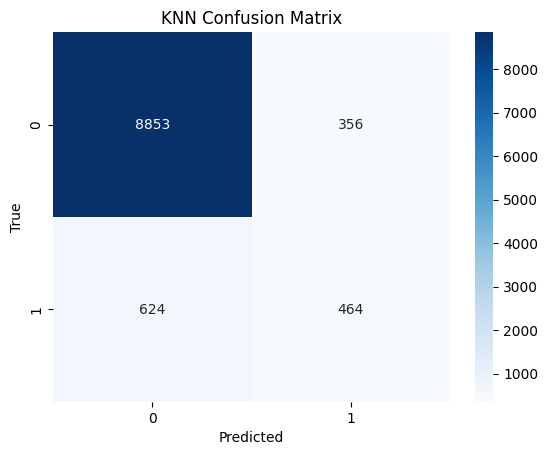

In [359]:
# Plot confusion matrix
y_pred = knn_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('KNN Confusion Matrix')
plt.show()

In [360]:
print(f"KNN classifier model train time = {knn_train_time: .4f} sec")
print(f"KNN classifier model train acc = {knn_train_acc}")
print(f"KNNclassifier model test acc = {knn_test_acc}")

KNN classifier model train time =  0.0058 sec
KNN classifier model train acc = 0.92823152374478
KNNclassifier model test acc = 0.9048266485384092


In [361]:
# Build a pipeline for Decision Tree classifier
dtc_model = Pipeline(
    steps = [
        ('classifier', DecisionTreeClassifier()) 
    ]
)

st = time.time()
dtc_model.fit(X_train, y_train)
et = time.time()

dtc_train_time = et - st
dtc_train_acc = dtc_model.score(X_train, y_train)
dtc_test_acc = dtc_model.score(X_test, y_test)

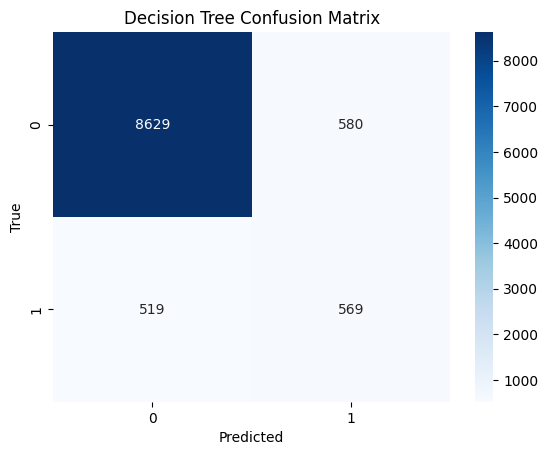

In [362]:
# Plot confusion matrix
y_pred = dtc_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Decision Tree Confusion Matrix')
plt.show()

In [363]:
print(f"Decision tree classifier model train time = {dtc_train_time: .4f} sec")
print(f"Decision tree classifier model train acc = {dtc_train_acc}")
print(f"Decision tree classifier model test acc = {dtc_test_acc}")

Decision tree classifier model train time =  0.3030 sec
Decision tree classifier model train acc = 1.0
Decision tree classifier model test acc = 0.8932698844323589


In [364]:
# Build a pipeline for SVM classifier
svc_model = Pipeline(
    steps = [
        ('classifier', SVC()) 
    ]
)

st = time.time()
svc_model.fit(X_train, y_train)
et = time.time()

svc_train_time = et - st
svc_train_acc = svc_model.score(X_train, y_train)
svc_test_acc = svc_model.score(X_test, y_test)

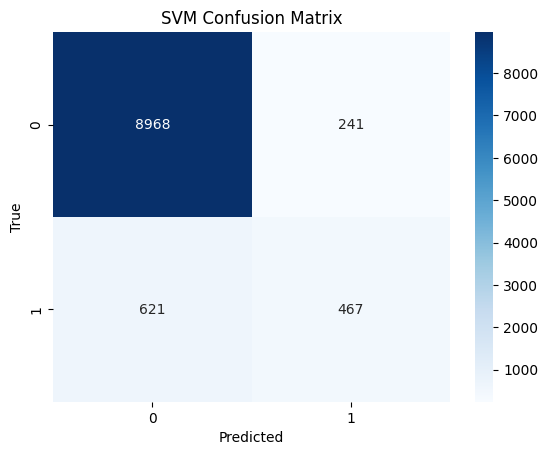

In [365]:
# Plot confusion matrix
y_pred = svc_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('SVM Confusion Matrix')
plt.show()

In [366]:
print(f"SVM classifier model train time = {svc_train_time: .4f} sec")
print(f"SVM classifier model train acc = {svc_train_acc}")
print(f"SVM classifier model test acc = {svc_test_acc}")

SVM classifier model train time =  8.6437 sec
SVM classifier model train acc = 0.9220808649768542
SVM classifier model test acc = 0.9162862969797029


In [367]:
df = pd.DataFrame(
    {
        'Model': ['Logistic Regression', 'Decision Tree', 'KNN', 'SVM'],
        'Train Time': [lgr_train_time, dtc_train_time, knn_train_time, svc_train_time],
        'Train Accuracy': [lgr_train_acc, dtc_train_acc, knn_train_acc, svc_train_acc],
        'Test Accuracy': [lgr_test_acc, dtc_test_acc, knn_test_acc, svc_test_acc]
    }
)

In [368]:
print(df)

                 Model  Train Time  Train Accuracy  Test Accuracy
0  Logistic Regression    0.091597        0.910524       0.913664
1        Decision Tree    0.302994        1.000000       0.893270
2                  KNN    0.005806        0.928232       0.904827
3                  SVM    8.643723        0.922081       0.916286


#### SVM classifier has the best accuracy

### Problem 11: Improving the Model

Now that we have some basic models on the board, we want to try to improve these.  Below, we list a few things to explore in this pursuit.

- More feature engineering and exploration.  For example, should we keep the gender feature?  Why or why not?
- Hyperparameter tuning and grid search.  All of our models have additional hyperparameters to tune and explore.  For example the number of neighbors in KNN or the maximum depth of a Decision Tree.  
- Adjust your performance metric

#### Improve SVM model

In [369]:
# Select most important features

sel_numeric_features = ['age', 'duration', 'campaign', 'pdays', 'previous']
sel_categorical_features = ['default', 'housing', 'loan']

print(f"Number of numeric features = {len(numeric_features)}")
print(f"Number of categorical features = {len(categorical_features)}")

Number of numeric features = 10
Number of categorical features = 10


In [370]:
# Transform columns. Numeric values are scaled and categorical values are one hot encoded.
sel_processor = ColumnTransformer(
    transformers = [
        ('num', StandardScaler(), sel_numeric_features),
        ('cat', OneHotEncoder(), sel_categorical_features)
    ]
)
processor.fit(X)
X_transformed = processor.transform(X)

In [371]:
X_train, X_test, y_train, y_test = train_test_split(X_transformed, y)

In [372]:
params = {
    'classifier__C': [1, 10],                # Regularization parameter
    'classifier__kernel': ['rbf', 'poly'],   # Kernel types
}

grid = GridSearchCV(
    estimator=svc_model,
    param_grid=params,
    scoring="accuracy"
)

In [373]:
grid.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('classifier', SVC())]),
             param_grid={'classifier__C': [1, 10],
                         'classifier__kernel': ['rbf', 'poly']},
             scoring='accuracy')

In [374]:
print(f"SVM best params = {grid.best_params_}")
print(f"SVM best score = {grid.best_score_}")

SVM best params = {'classifier__C': 1, 'classifier__kernel': 'rbf'}
SVM best score = 0.9111390825481582


In [375]:
optimized_svc_model_score = grid.score(X_test, y_test)

In [376]:
print(f"Optimized SVC model score = {optimized_svc_model_score}")

Optimized SVC model score = 0.9130814800427309


#### Improve Logistic Regression model

In [377]:
# select hyper-parameter to tune for training
params = {
    'classifier__penalty': ['l1', 'l2'],        # Regularization types
    'classifier__C': [1, 10],        # Inverse of regularization strength
    'classifier__solver': ['liblinear']
}
grid = GridSearchCV(
    estimator=lgr_model,
    param_grid=params,
    scoring="accuracy"
)

In [378]:
# train
grid.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('classifier', LogisticRegression())]),
             param_grid={'classifier__C': [1, 10],
                         'classifier__penalty': ['l1', 'l2'],
                         'classifier__solver': ['liblinear']},
             scoring='accuracy')

In [379]:
print(f"Logistic regression best params = {grid.best_params_}")
print(f"Logistic regresssion best score = {grid.best_score_}")

Logistic regression best params = {'classifier__C': 1, 'classifier__penalty': 'l1', 'classifier__solver': 'liblinear'}
Logistic regresssion best score = 0.9116570180926417


In [380]:
optimized_lgr_model_score = grid.score(X_test, y_test)

In [381]:
print(f"Optimized Linear Regression model score = {optimized_lgr_model_score}")

Optimized Linear Regression model score = 0.910556472759056


##### Questions